In [1]:
import pandas as pd
import numpy as np
import os
import sys

# !pip install librosa
# !pip install lifelines
# !pip install np_utils
# !pip install tensorflow

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

## Importing and Splitting the datasets

In [2]:
#importing the datasets
train_set = pd.read_csv('outputs/train_set_ov2_no_mismatch.csv')
test_set = pd.read_csv('outputs/test_set_ov2_no_mismatch.csv')

In [3]:
#Split into features and target; x = features, y = target
x_train = train_set.iloc[:, 1:]
y_train = train_set['label']

x_test = test_set.iloc[:, 1:]
y_test = test_set['label']

#combining test and train set for cross validation
x = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])

In [4]:
x_test

,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,lm_4_x,...,lm_475_z,lm_476_x,lm_476_y,lm_476_z,lm_477_x,lm_477_y,lm_477_z,lm_478_x,lm_478_y,lm_478_z
0,0.491400,0.732320,-0.054371,0.485835,0.661711,-0.142432,0.489872,0.676943,-0.072369,0.467857,...,-0.012128,0.626934,0.445669,-0.012127,0.600117,0.469423,-0.012155,0.626503,0.492920,-0.012152
1,0.515338,0.618809,-0.027641,0.520669,0.569473,-0.110649,0.516733,0.578083,-0.047346,0.495328,...,-0.018651,0.630938,0.368347,-0.018649,0.613579,0.387337,-0.018672,0.633811,0.402824,-0.018671
2,0.510069,0.679696,-0.071083,0.520436,0.597828,-0.137022,0.514391,0.623089,-0.075861,0.491742,...,0.034499,0.614713,0.447929,0.034502,0.589599,0.468398,0.034472,0.615148,0.488124,0.034479
3,0.504052,0.716384,-0.037302,0.508079,0.656141,-0.126209,0.504914,0.671283,-0.056388,0.484088,...,-0.005355,0.617545,0.446876,-0.005354,0.593047,0.469114,-0.005385,0.618375,0.489911,-0.005381
4,0.510106,0.705631,-0.089607,0.501306,0.596600,-0.154930,0.504797,0.633559,-0.084937,0.473188,...,0.027544,0.642669,0.397099,0.027547,0.614630,0.422473,0.027513,0.642357,0.448079,0.027519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,0.482593,0.718526,-0.064106,0.469306,0.640415,-0.131103,0.477639,0.663581,-0.071532,0.455022,...,0.004841,0.630023,0.445232,0.004842,0.604482,0.466323,0.004816,0.629380,0.487871,0.004818
2636,0.478807,0.702516,-0.064206,0.466731,0.617996,-0.130047,0.475330,0.640948,-0.070059,0.453466,...,-0.009315,0.629221,0.444486,-0.009318,0.606545,0.462531,-0.009343,0.627597,0.482280,-0.009339
2637,0.489660,0.727882,-0.057233,0.491185,0.623539,-0.142210,0.491912,0.646457,-0.066818,0.467872,...,0.003427,0.629216,0.390856,0.003430,0.601153,0.416639,0.003394,0.629049,0.442369,0.003398
2638,0.499108,0.682507,-0.068565,0.503425,0.585846,-0.135804,0.501222,0.612962,-0.069593,0.482207,...,0.029519,0.633312,0.397255,0.029521,0.608004,0.419239,0.029489,0.632230,0.443043,0.029497


In [5]:
y_test

0         happy
1         anger
2         happy
3         happy
4           sad
         ...   
2635      happy
2636      happy
2637    neutral
2638      anger
2639      happy
Name: label, Length: 2640, dtype: object

In [6]:
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#Get the labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

y_test

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [7]:
scaler = StandardScaler()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10564, 1434), (10564, 4), (2640, 1434), (2640, 4))

In [9]:
model= Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1434, 256)         1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 717, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 717, 256)          327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 359, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 359, 256)          327936    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 180, 256)        

In [10]:
checkpoint_filepath = os.getcwd() + '/ckpt_cnn/Epoch{epoch:02d}_{accuracy:.2f}.keras'
checkpoint_filepath

'C:\\Users\\Aaron\\Desktop\\Github Projects\\AFFECTV-XX22-Project\\Data Cleaning & Model Training/ckpt_cnn/Epoch{epoch:02d}_{accuracy:.2f}.keras'

In [11]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='accuracy',
    mode='max')

In [12]:
rlrp = ReduceLROnPlateau(monitor='accuracy', factor=0.8, verbose=1, patience=2, min_lr=0.0001)
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test), callbacks=[rlrp, model_checkpoint_callback])

Epoch 1/30


166/166 [==============================] - 69s 411ms/step - loss: 1.3498 - accuracy: 0.3068 - val_loss: 1.4242 - val_accuracy: 0.1235 - lr: 0.0010
Epoch 2/30
166/166 [==============================] - 69s 414ms/step - loss: 1.2649 - accuracy: 0.3716 - val_loss: 1.2448 - val_accuracy: 0.1462 - lr: 0.0010
Epoch 3/30
166/166 [==============================] - 68s 413ms/step - loss: 1.2193 - accuracy: 0.4176 - val_loss: 1.1254 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 4/30
166/166 [==============================] - 71s 428ms/step - loss: 1.1040 - accuracy: 0.4907 - val_loss: 0.8944 - val_accuracy: 0.6595 - lr: 0.0010
Epoch 5/30
166/166 [==============================] - 69s 414ms/step - loss: 1.0260 - accuracy: 0.5230 - val_loss: 0.6715 - val_accuracy: 0.7193 - lr: 0.0010
Epoch 6/30
166/166 [==============================] - 67s 405ms/step - loss: 1.0237 - accuracy: 0.5045 - val_loss: 0.6703 - val_accuracy: 0.7223 - lr: 0.0010
Epoch 7/30
165/166 [============================>.

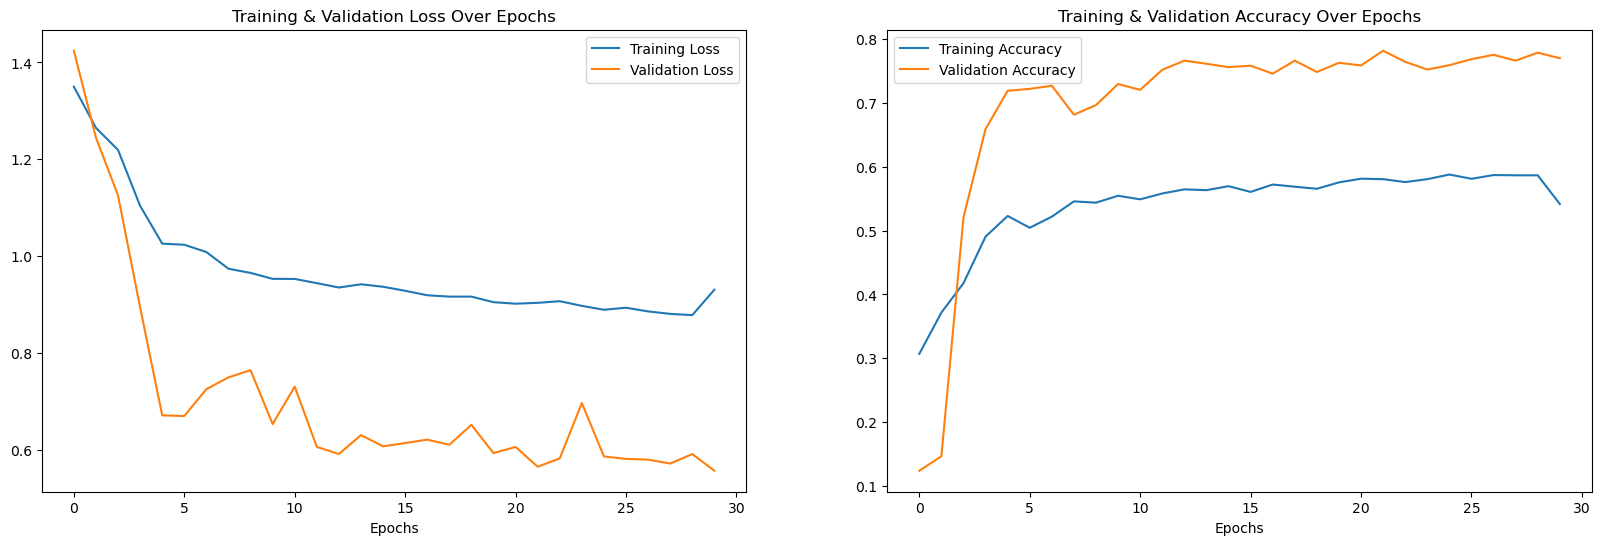

In [13]:
epochs = [i for i in range(30)]
fig, ax = plt.subplots(1,2)
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
test_accuracy = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss, label = 'Training Loss')
ax[0].plot(epochs, test_loss, label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss Over Epochs')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_accuracy, label = 'Training Accuracy')
ax[1].plot(epochs, test_accuracy, label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy Over Epochs')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [14]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

83/83 [==============================] - 4s 49ms/step


In [15]:
y_pred

array([['happy'],
       ['anger'],
       ['happy'],
       ...,
       ['anger'],
       ['anger'],
       ['happy']], dtype=object)

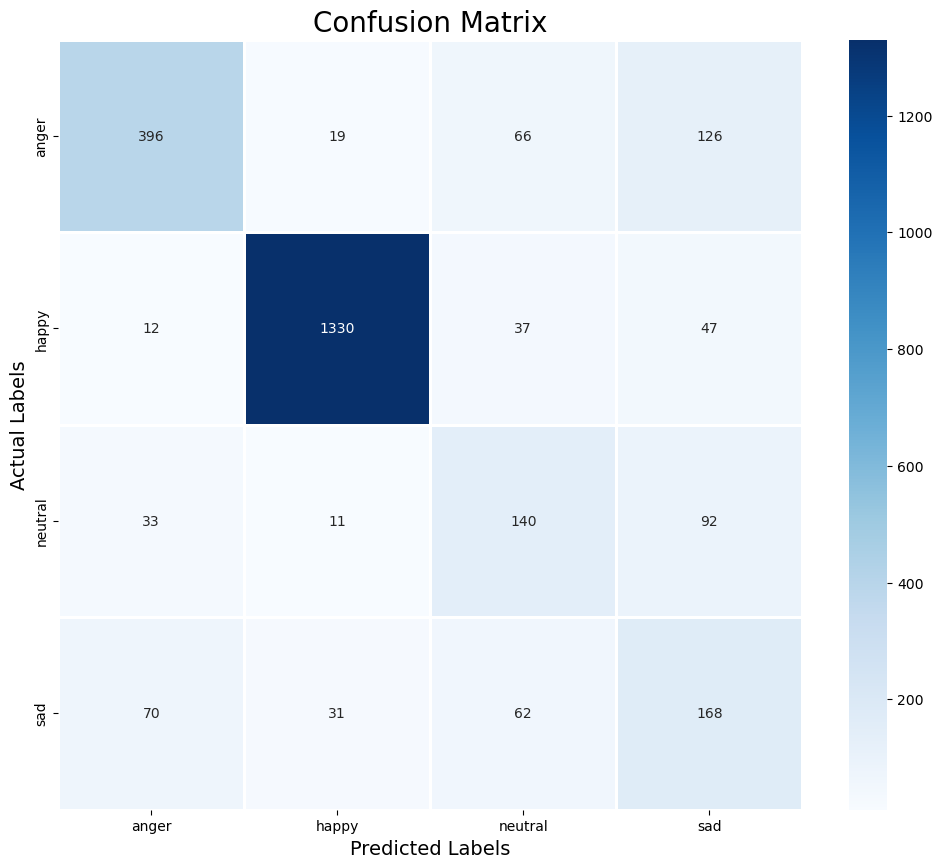

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

acs_test = accuracy_score(y_test,y_pred)
ps_test = precision_score(y_test,y_pred, average = "macro")
rs_test = recall_score(y_test,y_pred,  average = "macro")
fs_test = f1_score(y_test,y_pred,  average = "macro")

print("Accuracy Score: ", "{:.2%}".format(acs_test))
print("Precision Score: ", "{:.2%}".format(ps_test))
print("Recall Score: ", "{:.2%}".format(rs_test))
print("F1 Score: ", "{:.2%}".format(fs_test))

Accuracy Score:  77.05%
Precision Score:  64.45%
Recall Score:  65.00%
F1 Score:  64.36%
